In [17]:
import numpy as np

In [18]:
c = np.array([[1,0,0,0,0,0,0,]])
w = np.random.randn(7,3)
h = np.dot(c,w)
print(h)

[[-1.48618104  0.21551717 -0.57530677]]


In [19]:
import sys
sys.path.append('..')
from common.layers import MatMul, SoftmaxWithLoss

c0 = np.array([[1,0,0,0,0,0,0,]])
c1 = np.array([[0,0,1,0,0,0,0]])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

In [20]:
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [21]:
def create_contexts_target(corpus, window_size =1):
    target = corpus[window_size: -window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size +1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

contexts, target = create_contexts_target(corpus, window_size =1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [22]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [23]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V,H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01*np.random.randn(h,V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vecs =W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (h0 + h1)*0.5
        score = self.out_layer.forward(h)
        loss  = self.loss_layer.forward(score,target)
        return loss

In [24]:
from common.trainer import Trainer
from common.optimizer import Adam 
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

ModuleNotFoundError: No module named 'simple_cbow'

In [ ]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vacab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [ ]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])


In [ ]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

### ch4

In [ ]:
class Embedding:
    def __init__(self,W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    def forward(self, idx):
            W, = self.params
            self.idx = idx
            out = W[idx]
            return out
    def backward(self, dout):
            dw, = self.grads
            dw[...] = 0
           
            for i , word_id in enumerate(self.idx):
                dw[word_id] += dout[i]
            
            return None

In [ ]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    def forward(self, h ,idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        self.cache = (h, target_W)
        return out
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0],1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [ ]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power = 0.75, sample_size = 5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(courpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size +1)]
        self.emped_dot_layers = [EmbeddingDot(W) for _ in range(sample_size +1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_nagetive_sample(target)
        
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:,i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_laers[1 + i].forward(score, negative_label)
        return loss   
    
    def backward(self, dout=1):
            dh = 0
            for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
                dscore = l0.backward(dout)
                dh += l1.backward(dscore)
            return dh

In [25]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H  = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out,corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs =W_in

In [28]:
def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
        h += layer.forward(contexts[:, i])
    h *= 1 /len(self.in_layers)
    loss = self.ns_loss.forward(h,target)
    return loss

def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout*= 1/ len(self.in_layers)
        for layer in self.in_layers:
              layer.backward(dout)
        return None

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common import config
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)
    
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
tainer.plot()

word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs']  =word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id 
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb')as f:
    pickle.dump(params, f, -1)

Done
| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 1[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 2[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 2[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 3[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 3[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 4[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 5[s] | loss 3.48
| epoch 1 |  iter 181 / 9295 | time 5[s] | loss 3.36
| epoch 1 |  iter 201 / 9295 | time 6[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 7[s] | loss 3.14
| epoch 1 |  iter 241 / 9295 | time 7[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 8[s] | loss 3.00
| epoch 1 |  iter 281 / 9295 | time 8[s] | loss 2.95
| epoch 1 |  iter 301 / 9295 | time 9[s] | loss 2.93
| epoch 1 |  iter 321 / 9295 | time 10[s] | loss 2.87
| epoch 1 |  iter 341 / 9295 | time 10[s] | loss 2.85
| epoch 1 |  iter 361 / 9295 | time 11[s] | l

| epoch 1 |  iter 3001 / 9295 | time 94[s] | loss 2.46
| epoch 1 |  iter 3021 / 9295 | time 95[s] | loss 2.47
| epoch 1 |  iter 3041 / 9295 | time 96[s] | loss 2.44
| epoch 1 |  iter 3061 / 9295 | time 96[s] | loss 2.45
| epoch 1 |  iter 3081 / 9295 | time 97[s] | loss 2.45
| epoch 1 |  iter 3101 / 9295 | time 98[s] | loss 2.40
| epoch 1 |  iter 3121 / 9295 | time 98[s] | loss 2.41
| epoch 1 |  iter 3141 / 9295 | time 99[s] | loss 2.42
| epoch 1 |  iter 3161 / 9295 | time 100[s] | loss 2.45
| epoch 1 |  iter 3181 / 9295 | time 100[s] | loss 2.44
| epoch 1 |  iter 3201 / 9295 | time 101[s] | loss 2.42
| epoch 1 |  iter 3221 / 9295 | time 101[s] | loss 2.41
| epoch 1 |  iter 3241 / 9295 | time 102[s] | loss 2.45
| epoch 1 |  iter 3261 / 9295 | time 103[s] | loss 2.41
| epoch 1 |  iter 3281 / 9295 | time 103[s] | loss 2.45
| epoch 1 |  iter 3301 / 9295 | time 104[s] | loss 2.43
| epoch 1 |  iter 3321 / 9295 | time 105[s] | loss 2.46
| epoch 1 |  iter 3341 / 9295 | time 105[s] | loss 2.44


| epoch 1 |  iter 5941 / 9295 | time 188[s] | loss 2.30
| epoch 1 |  iter 5961 / 9295 | time 189[s] | loss 2.31
| epoch 1 |  iter 5981 / 9295 | time 189[s] | loss 2.36
| epoch 1 |  iter 6001 / 9295 | time 190[s] | loss 2.35
| epoch 1 |  iter 6021 / 9295 | time 191[s] | loss 2.33
| epoch 1 |  iter 6041 / 9295 | time 191[s] | loss 2.32
| epoch 1 |  iter 6061 / 9295 | time 192[s] | loss 2.29
| epoch 1 |  iter 6081 / 9295 | time 193[s] | loss 2.33
| epoch 1 |  iter 6101 / 9295 | time 193[s] | loss 2.34
| epoch 1 |  iter 6121 / 9295 | time 194[s] | loss 2.34
| epoch 1 |  iter 6141 / 9295 | time 194[s] | loss 2.30
| epoch 1 |  iter 6161 / 9295 | time 195[s] | loss 2.30
| epoch 1 |  iter 6181 / 9295 | time 196[s] | loss 2.31
| epoch 1 |  iter 6201 / 9295 | time 196[s] | loss 2.29
| epoch 1 |  iter 6221 / 9295 | time 197[s] | loss 2.32
| epoch 1 |  iter 6241 / 9295 | time 198[s] | loss 2.31
| epoch 1 |  iter 6261 / 9295 | time 198[s] | loss 2.36
| epoch 1 |  iter 6281 / 9295 | time 199[s] | lo

| epoch 1 |  iter 8881 / 9295 | time 283[s] | loss 2.24
| epoch 1 |  iter 8901 / 9295 | time 283[s] | loss 2.21
| epoch 1 |  iter 8921 / 9295 | time 284[s] | loss 2.24
| epoch 1 |  iter 8941 / 9295 | time 285[s] | loss 2.24
| epoch 1 |  iter 8961 / 9295 | time 285[s] | loss 2.20
| epoch 1 |  iter 8981 / 9295 | time 286[s] | loss 2.22
| epoch 1 |  iter 9001 / 9295 | time 287[s] | loss 2.21
| epoch 1 |  iter 9021 / 9295 | time 287[s] | loss 2.21
| epoch 1 |  iter 9041 / 9295 | time 288[s] | loss 2.24
| epoch 1 |  iter 9061 / 9295 | time 288[s] | loss 2.25
| epoch 1 |  iter 9081 / 9295 | time 289[s] | loss 2.27
| epoch 1 |  iter 9101 / 9295 | time 290[s] | loss 2.21
| epoch 1 |  iter 9121 / 9295 | time 290[s] | loss 2.26
| epoch 1 |  iter 9141 / 9295 | time 291[s] | loss 2.22
| epoch 1 |  iter 9161 / 9295 | time 292[s] | loss 2.23
| epoch 1 |  iter 9181 / 9295 | time 292[s] | loss 2.20
| epoch 1 |  iter 9201 / 9295 | time 293[s] | loss 2.23
| epoch 1 |  iter 9221 / 9295 | time 294[s] | lo

| epoch 2 |  iter 2541 / 9295 | time 377[s] | loss 2.11
| epoch 2 |  iter 2561 / 9295 | time 378[s] | loss 2.14
| epoch 2 |  iter 2581 / 9295 | time 378[s] | loss 2.17
| epoch 2 |  iter 2601 / 9295 | time 379[s] | loss 2.15
| epoch 2 |  iter 2621 / 9295 | time 380[s] | loss 2.15
| epoch 2 |  iter 2641 / 9295 | time 380[s] | loss 2.10
| epoch 2 |  iter 2661 / 9295 | time 381[s] | loss 2.14
| epoch 2 |  iter 2681 / 9295 | time 382[s] | loss 2.13
| epoch 2 |  iter 2701 / 9295 | time 382[s] | loss 2.13
| epoch 2 |  iter 2721 / 9295 | time 383[s] | loss 2.13
| epoch 2 |  iter 2741 / 9295 | time 384[s] | loss 2.07
| epoch 2 |  iter 2761 / 9295 | time 384[s] | loss 2.16
| epoch 2 |  iter 2781 / 9295 | time 385[s] | loss 2.12
| epoch 2 |  iter 2801 / 9295 | time 386[s] | loss 2.13
| epoch 2 |  iter 2821 / 9295 | time 386[s] | loss 2.13
| epoch 2 |  iter 2841 / 9295 | time 387[s] | loss 2.13
| epoch 2 |  iter 2861 / 9295 | time 387[s] | loss 2.11
| epoch 2 |  iter 2881 / 9295 | time 388[s] | lo

| epoch 2 |  iter 5481 / 9295 | time 471[s] | loss 2.09
| epoch 2 |  iter 5501 / 9295 | time 472[s] | loss 2.07
| epoch 2 |  iter 5521 / 9295 | time 472[s] | loss 2.06
| epoch 2 |  iter 5541 / 9295 | time 473[s] | loss 2.06
| epoch 2 |  iter 5561 / 9295 | time 474[s] | loss 2.08
| epoch 2 |  iter 5581 / 9295 | time 474[s] | loss 2.05
| epoch 2 |  iter 5601 / 9295 | time 475[s] | loss 2.08
| epoch 2 |  iter 5621 / 9295 | time 475[s] | loss 2.06
| epoch 2 |  iter 5641 / 9295 | time 476[s] | loss 2.09
| epoch 2 |  iter 5661 / 9295 | time 477[s] | loss 2.08
| epoch 2 |  iter 5681 / 9295 | time 477[s] | loss 2.05
| epoch 2 |  iter 5701 / 9295 | time 478[s] | loss 2.08
| epoch 2 |  iter 5721 / 9295 | time 479[s] | loss 2.07
| epoch 2 |  iter 5741 / 9295 | time 479[s] | loss 2.04
| epoch 2 |  iter 5761 / 9295 | time 480[s] | loss 2.06
| epoch 2 |  iter 5781 / 9295 | time 481[s] | loss 2.08
| epoch 2 |  iter 5801 / 9295 | time 481[s] | loss 2.07
| epoch 2 |  iter 5821 / 9295 | time 482[s] | lo

| epoch 2 |  iter 8421 / 9295 | time 564[s] | loss 2.05
| epoch 2 |  iter 8441 / 9295 | time 565[s] | loss 2.08
| epoch 2 |  iter 8461 / 9295 | time 566[s] | loss 2.02
| epoch 2 |  iter 8481 / 9295 | time 566[s] | loss 1.99
| epoch 2 |  iter 8501 / 9295 | time 567[s] | loss 2.05
| epoch 2 |  iter 8521 / 9295 | time 568[s] | loss 2.00
| epoch 2 |  iter 8541 / 9295 | time 568[s] | loss 2.00
| epoch 2 |  iter 8561 / 9295 | time 569[s] | loss 1.99
| epoch 2 |  iter 8581 / 9295 | time 570[s] | loss 2.00
| epoch 2 |  iter 8601 / 9295 | time 570[s] | loss 2.04
| epoch 2 |  iter 8621 / 9295 | time 571[s] | loss 2.07
| epoch 2 |  iter 8641 / 9295 | time 571[s] | loss 2.03
| epoch 2 |  iter 8661 / 9295 | time 572[s] | loss 2.00
| epoch 2 |  iter 8681 / 9295 | time 573[s] | loss 2.00
| epoch 2 |  iter 8701 / 9295 | time 573[s] | loss 2.02
| epoch 2 |  iter 8721 / 9295 | time 574[s] | loss 1.98
| epoch 2 |  iter 8741 / 9295 | time 575[s] | loss 2.01
| epoch 2 |  iter 8761 / 9295 | time 575[s] | lo

| epoch 3 |  iter 2081 / 9295 | time 658[s] | loss 1.99
| epoch 3 |  iter 2101 / 9295 | time 659[s] | loss 1.92
| epoch 3 |  iter 2121 / 9295 | time 660[s] | loss 1.94
| epoch 3 |  iter 2141 / 9295 | time 660[s] | loss 1.96
| epoch 3 |  iter 2161 / 9295 | time 661[s] | loss 1.94
| epoch 3 |  iter 2181 / 9295 | time 662[s] | loss 1.96
| epoch 3 |  iter 2201 / 9295 | time 662[s] | loss 1.93
| epoch 3 |  iter 2221 / 9295 | time 667[s] | loss 1.94
| epoch 3 |  iter 2241 / 9295 | time 668[s] | loss 1.90
| epoch 3 |  iter 2261 / 9295 | time 668[s] | loss 1.97
| epoch 3 |  iter 2281 / 9295 | time 669[s] | loss 1.95
| epoch 3 |  iter 2301 / 9295 | time 670[s] | loss 1.92
| epoch 3 |  iter 2321 / 9295 | time 670[s] | loss 1.96
| epoch 3 |  iter 2341 / 9295 | time 671[s] | loss 1.99
| epoch 3 |  iter 2361 / 9295 | time 672[s] | loss 1.94
| epoch 3 |  iter 2381 / 9295 | time 672[s] | loss 1.94
| epoch 3 |  iter 2401 / 9295 | time 673[s] | loss 1.95
| epoch 3 |  iter 2421 / 9295 | time 674[s] | lo

| epoch 3 |  iter 5021 / 9295 | time 757[s] | loss 1.96
| epoch 3 |  iter 5041 / 9295 | time 757[s] | loss 1.93
| epoch 3 |  iter 5061 / 9295 | time 758[s] | loss 1.91
| epoch 3 |  iter 5081 / 9295 | time 759[s] | loss 1.91
| epoch 3 |  iter 5101 / 9295 | time 759[s] | loss 1.91
| epoch 3 |  iter 5121 / 9295 | time 760[s] | loss 1.93
| epoch 3 |  iter 5141 / 9295 | time 761[s] | loss 1.93
| epoch 3 |  iter 5161 / 9295 | time 761[s] | loss 1.91
| epoch 3 |  iter 5181 / 9295 | time 762[s] | loss 1.90
| epoch 3 |  iter 5201 / 9295 | time 763[s] | loss 1.93
| epoch 3 |  iter 5221 / 9295 | time 763[s] | loss 1.91


### ch5

In [1]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, wh, b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    def forward(self, x, h_prev):
            Wx, Wh, b = self.params
            t = np.dot(h_prev, Wh) + np.dot(x, Wx) +b
            h_next = np.tanh(t)
            
            self.cache = (x, h_prev, h_next)
            return h_next

In [2]:
def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next **2)
        db = np.sum(dt, axis = 0)
        dwh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dwx = np.dot(x.t, dt)
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, sateful = False):
            self.params = [Wx, Wh, b]
            self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
            self.layers = None
            self.h, self.dh = None, None
            self.sateful = stateful
            
    def set_state(self, h):
            self.h = h
            
    def reset_state(self):
            self.h = None

In [6]:
def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape
    
    self.layers = []
    hs = np.empty((N, T, H), dtype = 'f')
    
    if not self.stateful or self.h is None:
        self.h = np.zeros((N,H), dtype = 'f')
        
    for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t,:], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
    return hs

In [11]:
def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D,H = Wx.shape
        
        dxs = np.empty((N, T,D), dtype ='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
                layer = self.layers[t]
                dx, dh = layer.backward(dhs[:, t, :] + dh)
                dx[:, t, :] = dx
                for i, grad in enumerate(layer.grads):
                        grads[i] += grad
        for i ,grad in enumerate(grads):
                self.grads[i][...] = grad
        self.dh = dh
        return dxs

In [13]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randin
        
        # 重みの初期化
        embed_W = (rn(V,D)/ 100).astype('f')
        rnn_Wx = (rn(D,H)/ np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H,H)/ np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V)/ np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # すべtの重みと勾配をリストにまとめる
        self.params, self.grads = [],[]
        for layer in self.layers:
                self.params += layer.params
                self.grads += layer.grads

In [14]:
def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
                dout = layer.backward(dout)
        return dout
def reset_state(self):
        self.rnn_layer.reset_state()

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 398.30
| epoch 2 | perplexity 274.02
| epoch 3 | perplexity 224.20
| epoch 4 | perplexity 216.56
| epoch 5 | perplexity 206.69
| epoch 6 | perplexity 203.28
| epoch 7 | perplexity 197.89
| epoch 8 | perplexity 196.38
| epoch 9 | perplexity 191.93
| epoch 10 | perplexity 192.86
| epoch 11 | perplexity 188.37
| epoch 12 | perplexity 191.77
| epoch 13 | perplexity 189.48
| epoch 14 | perplexity 189.13
| epoch 15 | perplexity 188.31
| epoch 16 | perplexity 184.48
| epoch 17 | perplexity 182.71
| epoch 18 | perplexity 179.65
| epoch 19 | perplexity 180.08
| epoch 20 | perplexity 181.39
| epoch 21 | perplexity 179.33
| epoch 22 | perplexity 175.52
| epoch 23 | perplexity 173.36
| epoch 24 | perplexity 171.71
| epoch 25 | perplexity 172.16
| epoch 26 | perplexity 170.62
| epoch 27 | perplexity 163.21
| epoch 28 | perplexity 162.71
| epoch 29 | perplexity 159.36
| epoch 30 | perplexity 152.61
| epoch 31 | perplexity 155.63
| epoch 

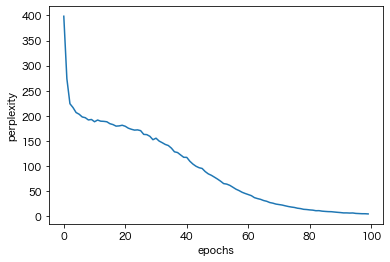

In [22]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


### ch06

In [2]:
class LSTM:
    def __init__(self, Wx, Wh, b):
            self.params = [Wx, Wh, b]
            self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
            self.cache = None

In [3]:
def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache - (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

In [8]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params  =[Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
            Wx, Wh, b = self.params
            N, T, D = xs.shape
            H = Wh.shape[0]
            
            self.layers = []
            hs = np.empty((N, T, H),dtype = 'f')
            
            if not self.stateful or self.h is None:
                self.h = np.zeros((N, H), dtype = 'f')
            if not self.stateful or self.c is None:
                self.c = np.zeros((N, H), dtype = 'f')
            
            for t in range(T):
                    layer  = LSTM(*self.params)
                    self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
                    hs[:, t, :] = self.h
                    
                    self.layers.append(layer)
                    
            return hs
        
    def backward(self, dhs):
            Wx, Wh, b = self.params
            N, T, H = dhs.shape
            D = Wx.shape[0]
            
            dxs = np.empty((N, T, D), dtype = 'f')
            dh, dc = 0,0
            
            grads = [0, 0, 0]
            for t in reversed(range(T)):
                layer = self.layers[t]
                dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
                dxs[:, t, :] = dx
                for i, grad in enumerate(layer.grads):
                    grads[i] += grad
            for i, grad in enumerate(grads):
                self.grads[i][...] = grad
                self.dh = dh
                return dxs
            
    def set_state(self, h, c =None):
                self.h, self.c = h,c
        
    def reset_state(self):
                self.h, self.c  =None, None

In [10]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size = 10000, wordvec_size = 100, hidden_size = 100):
            V, D, H = vocab_size, wordvec_size, hidden_size
            rn = np.rondom.randn
            
            # 重みの初期化
            embed_W = (rn(V,D) / 100).astype('f')
            lstm_Wx = (rn(D, 4 * H)/ np.sqrt(D)).astype('f')
            lstm_Wh = (rn(H, 4 * H)/ np.sqrt(H)).astype('f')
            lstm_b = np.zeros(4 * H).astype('f')
            affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
            affine_b = np.zeros(V).astype('f')
            
            self.layers = [
                TimeEmbedding(embed_W),
                TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True),
                TimeAffine(affine_W, affine_b)
            ]
            self.loss_layer = TimeSoftbaxWithLoss()
            self.lstm_layer = self.layers[1]
            
            # すべての重みと勾配をリストにまとめる
            self.params, self.grads = [], []
            for layer in self.layers:
                    self.params += layer.params
                    self.grads += layer.grads
    def predict(self, xs):
            for layer in self.layers:
                xs = layer.forward(xs)
            return xs
        
    def forward(self, xs, ts):
            score = self.predict(xs)
            loss = self.loss_layer.forward(score, ts)
            return loss
    
    def backward(self, dout = 1):
            dout = self.loss_layer.backward(dout)
            for layer in reversed(seld.layers):
                dout = layer.backward(dout)
            return dout 
    
    def reset_state(self):
            self.lstm_layer.reset_state()
            
    def save_params(self, file_name = 'Rnnlm.pkl'):
            with open(file_name, 'wb') as f :
                pickle.dump(self.params, f)
    
    def load_params(self, file_name = 'Rnnlm.pkl'):
            with open(file_name, 'rb') as f:
                self.params = pickle.load(f)

In [9]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTMレイヤを2層利用し、各層にDropoutを使うモデル
     [1]で提案されたモデルをベースとし、weight tying[2][3]を利用

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


### ch07

まず初めに、ch06で作ったRnnlmのクラスを継承し追加する。

In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_id, skip_ids = None, sample_size = 100):
            word_ids = [start_id]
            
            x = start_id
            while len(word_size) < smaple_size:
                x = np.array(x).reshape(1,1)
                score = self.predict(x)
                p = softmax(score.flatten())
                
                sampled  = np.random.choice(len(p), size = 1, p=p)
                if(skip_ids is None) or (sampled not in skip_ids):
                    x = sampled
                    word_ids.append(int(x))
            return word_ids

In [6]:
import sys
sys.path.append('..')
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace('<eos>', '.\n')
print(txt)

you fiscal hot-dipped fusion homes personal-computer department activity nervous mass-market blessing tackle metals electrical peripheral guests nationwide beers current processed broadway views norton electronics is girlfriend gubernatorial waertsilae cigarette dioxide dioxide applicants prerogatives reminded integrity violent bench necessity mount cox stress-related venerable three-month minerals pile investigated necessarily ken gathered restored interpret cautious intel soo now fixed-price loss bottom steelmaker status seasonally billing absence communities kick wrongdoing instrumental patrick dignity lawmakers how outsiders wheels o'connell views interpreted cathcart privilege dpc entitled treating windows restored besides engineers completely saying restriction hispanic salomon suitor peterson renewed witness natural-gas phrase trucks party peabody arteries


作成した文章は、PTBデータ内の文字を羅列したものに過ぎない

In [8]:
import sys
sys.path.append('..')
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('../ch06/Rnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace('<eos>', '.\n')
print(txt)

you had billed when the nation 's largest council failed to contain the transferred .
 an investment banking index posted the deal targets for ginnie mae losses for the debate seasonal positions .
 one of these victims bolstered by vast demands that is falling .
 he wo n't waive the european stock market .
 the proposals plan to crush union aviation european nations from several defendants and leaders to bolster marketing .
 analysts have run their stake and an violence order against their state and congress not mind .
 mr. roman took prove to make republican criminal joint petroleum 's


model.load_params('../ch06/Rnnlm.pkl')
上記内容を追加したことによって、文章全体の構成がいまいちでも、主語と同士の関係や、名詞と形容詞の形が正しく表現されている。

In [12]:
import sys
sys.path.append('..')
from common.np import *
from rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('../ch06/BetterRnnlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)

you can stop it.
 he also cited the stage of the city 's central bank barron 's short history in recent years with an appeal to illegal use in the hispanic agenda.
 the old crowd doing mccall is proud of what happened in the house of representatives.
 logic they attempts to sacrifice asia in washington then in the state as the future of the script.
 in the almost two years of japan 's largest metropolitan limits its own pursued image is supposed to be larger among the most sophisticated u.s. operations according to mr..
 no


seq2seqを使った足し算の例

In [13]:
import sys
sys.path.append('..')
from dataset import sequence

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
cahr_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)


In [14]:
print(x_train[0])
print(t_train[0])

[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]


In [17]:
print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

71+118 
_189 


In [26]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        self.embed = TimeEmbedding(embe_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

In [27]:
def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [28]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V,D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_w = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
                self.params += layer.params
                self.grads += layer.grads
                
    def forward(self, xs, h):
            self.lstm.set_state(h)
            
            out = self.embed.forward(xs)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            return score
        
    def backward(self, dscore):
            dout = self.affine.backward(dscore)
            dout = self.lstm.backward(dout)
            dout = self.embed.backward(dout)
            dh = self.lstm.dh
            return dh

In [29]:
def generate(self, h, start_id, sample_size):
        sampled = []
        samle_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1,1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = mp.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled

In [30]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V,D,H)
        self.decoder = Decoder(V,D,H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
            decoder_xs, decoder_ts = ts[:, :-1], ts[:,1:]
            
            h = self.encoder.forward(xs)
            score = self.decoder.forward(decoder_xs, h)
            loss = self.softmax.forward(score, decoder_ts)
            return loss
    def backward(self, dout =1):
            dout = self.softmax.backward(dout)
            dh = self.decoder.backward(dout)
            dout =self.encoder.backward(dh)
            return dout
    def generate(self, xs, start_id, sample_size):
            h = self.encoder.forward(xs)
            sampled = self.decoder.generate(h, start_id, sample_size)
            return sampled

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 0[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 2[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 2[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 3[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 3[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 4[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 4[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 5[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 5[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 6[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 6[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 6[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 7[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 7[s] | loss 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 66

| epoch 7 |  iter 121 / 351 | time 3[s] | loss 1.08
| epoch 7 |  iter 141 / 351 | time 4[s] | loss 1.08
| epoch 7 |  iter 161 / 351 | time 4[s] | loss 1.08
| epoch 7 |  iter 181 / 351 | time 5[s] | loss 1.09
| epoch 7 |  iter 201 / 351 | time 6[s] | loss 1.08
| epoch 7 |  iter 221 / 351 | time 6[s] | loss 1.07
| epoch 7 |  iter 241 / 351 | time 7[s] | loss 1.05
| epoch 7 |  iter 261 / 351 | time 7[s] | loss 1.05
| epoch 7 |  iter 281 / 351 | time 8[s] | loss 1.06
| epoch 7 |  iter 301 / 351 | time 8[s] | loss 1.06
| epoch 7 |  iter 321 / 351 | time 9[s] | loss 1.06
| epoch 7 |  iter 341 / 351 | time 9[s] | loss 1.05
Q 77+85  
T 162 
☒ 156 
---
Q 975+164
T 1139
☒ 1166
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 161 
---
Q 367+55 
T 422 
☒ 407 
---
Q 600+257
T 857 
☒ 893 
---
Q 761+292
T 1053
☒ 1107
---
Q 830+597
T 1427
☒ 1444
---
Q 26+838 
T 864 
☒ 867 
---
Q 143+93 
T 236 
☒ 227 
---
val acc 3.820%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 1.07
| epoch 8 |  iter 21 / 351 | ti

| epoch 13 |  iter 221 / 351 | time 5[s] | loss 0.89
| epoch 13 |  iter 241 / 351 | time 5[s] | loss 0.89
| epoch 13 |  iter 261 / 351 | time 5[s] | loss 0.93
| epoch 13 |  iter 281 / 351 | time 6[s] | loss 0.91
| epoch 13 |  iter 301 / 351 | time 6[s] | loss 0.89
| epoch 13 |  iter 321 / 351 | time 7[s] | loss 0.89
| epoch 13 |  iter 341 / 351 | time 7[s] | loss 0.91
Q 77+85  
T 162 
☒ 158 
---
Q 975+164
T 1139
☒ 1121
---
Q 582+84 
T 666 
☒ 659 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 846 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1404
---
Q 26+838 
T 864 
☒ 857 
---
Q 143+93 
T 236 
☒ 239 
---
val acc 5.040%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.93
| epoch 14 |  iter 21 / 351 | time 0[s] | loss 0.92
| epoch 14 |  iter 41 / 351 | time 0[s] | loss 0.91
| epoch 14 |  iter 61 / 351 | time 1[s] | loss 0.91
| epoch 14 |  iter 81 / 351 | time 1[s] | loss 0.91
| epoch 14 |  iter 101 / 351 | time 2[s] | loss 0.92
| epoch 14 |  iter 121

| epoch 19 |  iter 301 / 351 | time 7[s] | loss 0.84
| epoch 19 |  iter 321 / 351 | time 7[s] | loss 0.84
| epoch 19 |  iter 341 / 351 | time 8[s] | loss 0.84
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1126
---
Q 582+84 
T 666 
☒ 667 
---
Q 8+155  
T 163 
☒ 157 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 851 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1410
---
Q 26+838 
T 864 
☒ 867 
---
Q 143+93 
T 236 
☒ 237 
---
val acc 7.460%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.83
| epoch 20 |  iter 21 / 351 | time 0[s] | loss 0.82
| epoch 20 |  iter 41 / 351 | time 0[s] | loss 0.83
| epoch 20 |  iter 61 / 351 | time 1[s] | loss 0.83
| epoch 20 |  iter 81 / 351 | time 1[s] | loss 0.83
| epoch 20 |  iter 101 / 351 | time 2[s] | loss 0.83
| epoch 20 |  iter 121 / 351 | time 2[s] | loss 0.83
| epoch 20 |  iter 141 / 351 | time 3[s] | loss 0.86
| epoch 20 |  iter 161 / 351 | time 3[s] | loss 0.85
| epoch 20 |  iter 181 / 351 | time 4[s] | loss 0.81
| epoch 20 |  iter 201

val acc 12.300%


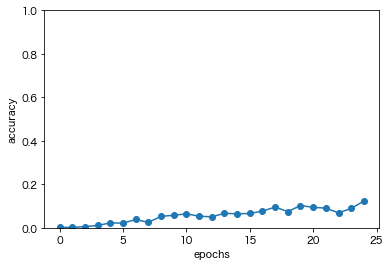

In [35]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Normal or Peeky? ==============================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()